# カルマンフィルタについての実験的コード
[こちら](https://www.kalmanfilter.net/JP/alphabeta_jp.html)の記事を参考にしている．

記号などは参考の記事に若干の変更を加えている．

（注）notebookの数式環境のeqrefがバグってるかも。。。

->（20240609）eqref参照せず，ベタ打ちした

## カルマンフィルタとは
1. 観測データからシステムの状態を推定（補正）する方法

## 問題設定１ 静的システム
性的システムを推定する．（質量を時間変化しないものとする＝静的システム，質量のようなもの）

- $x$: 状態量
- $\hat{x}_n$: n回目の推定値
- $z_n$: n回目の測定で得られた観測値

$\hat{x}_n$を

$$
\hat{x}_n = \frac{1}{n}\sum_{i=1}^{n}z_i \tag{1}
$$
と定義する．なおこのとき，$\hat{x}_n$は観測値の平均と捉えることができる．

この元で，
$$
\begin{align}
    \hat{x}_n &= \frac{1}{n}\sum_{i=1}^{n}z_i  \\
    &= \frac{1}{n}\left( z_n + \sum_{i=1}^{n-1}z_i \right) \\
    &= \frac{1}{n}z_n + \frac{n-1}{n} \cdot \frac{1}{n-1} \sum_{i=1}^{n-1}z_i \tag{2} 
\end{align} 
$$
となる．
ここで，
$$
\hat{x}_{n-1} = \frac{1}{n-1}\sum_{i=1}^{n-1}z_i
$$
であるから，$(2)$式は
$$
\begin{align}
    \hat{x}_n &= \frac{1}{n}z_n + \frac{n-1}{n} \cdot \frac{1}{n-1} \sum_{i=1}^{n-1}z_i \\
    &= \frac{1}{n}z_n + \frac{n-1}{n} \hat{x}_{n-1} \\
    &= \hat{x}_{n-1} + \frac{1}{n} (z_n - \hat{x}_{n-1}) \tag{3}
\end{align} 
$$
と書ける．ここで，$(1)$式を用いると，全ての観測値$z_k,\,\, k=\{1 \cdots n\}$を保存しておく必要があったが，$(3)$式では，$n$回目の観測値と$n-1$回目の推定値があれば計算可能であることに注意する．

なお，$(3)$式の$\frac{1}{n}$はカルマンゲインと呼ばれ，問題固有の値である．このカルマンゲインを$K_n$とすると，一般に$(3)$は，
$$
\begin{align}
    \hat{x}_n = \hat{x}_{n-1} + K_n (z_n - \hat{x}_{n-1}) \tag{4}
\end{align} 
$$
と書け，これを状態更新式という．この式は次のような意味である．
$$
補正された現在の状態の推定値　＝　前の状態→現在の状態の補正された予測値　+　補正値　×　(現在の状態の観測値　ー　前の状態→現在の状態の補正された予測値)
$$

In [24]:
import numpy as np
import matplotlib.pyplot as plt
m = 100 # 真の質量
n = 20 # 測定回数
rng = np.random.default_rng(111)
noise = rng.normal(loc=0.0, scale=1.0, size=(n, 1)) # ノイズ
observe_f = np.hstack([np.ones(n).reshape(-1,1), noise]) # 状態から観測量を得る関数（＝ベクトル）
observables = observe_f @ np.array([[m],[1]])# 観測値 = 真の値＋ノイズ
# 状態更新式によってより近い推定値を求める
x_hat = 99.26
x_hats = np.array([x_hat])
for i in range(1, n):
    K_n = 1/i
    #K_n = 0.1
    x_hat = x_hat + K_n * (observables[i-1, :] - x_hat)
    x_hats = np.append(x_hats, x_hat)

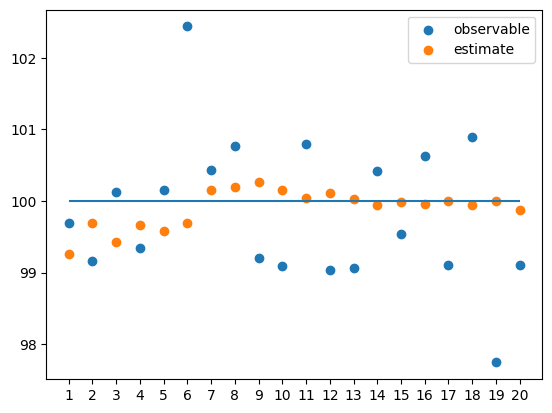

In [25]:
plt.hlines(xmin=1, xmax=n, y=m)
plt.scatter(np.arange(1, n+1), observables, label="observable")
plt.scatter(np.arange(1, n+1), x_hats, label="estimate")
plt.xticks(np.arange(1, n+1))
plt.legend()
plt.show()

## 問題設定２　動的システム（１次元系）
等速運動をする物体の位置を$x$として，それを推定する．（具体的には，飛んでる飛行機の位置座標を$x$として，レーダーを用いて観測する）

今，時刻$n$における物体の位置および速度をそれぞれ$\boldsymbol{x}_n,\, \boldsymbol{v}_n$とする．このとき，$\dot{\boldsymbol{x}}$を
$$
\dot{\boldsymbol{x}} = \boldsymbol{v} = \frac{d\boldsymbol{x}}{dt}
$$
とし，物体の位置を観測する時間間隔を$\Delta t$として$\boldsymbol{v}$を離散化すれば，
$$
\boldsymbol{v} = \frac{\Delta x}{\Delta t}
$$
である．また，位置に関して，
$$
\boldsymbol{x}_{n+1} = \boldsymbol{x}_n + \Delta t \dot{\boldsymbol{x}}_n \tag{1}
$$
である．さらに，等速運動であるので
$$
\dot{\boldsymbol{x}}_{n+1} = \dot{\boldsymbol{x}}_n
$$
である．これら２式を状態方程式と呼び，現在の状態から次の状態の予測値を与える方程式である．

